# Extensions

The wrapper class functionalities can be extended using composition or inheritance.

The concept of composition adds a component to a composite class. The relationship is such, that the composite class does not know the component class but wise versa. This allows to add additional functionality without changing the original code. Adding components to an existing wrapper class will be called "registering" here.

Concretely, four different so-called accessory classes are implemented:
- `Vector`
- `Magnitude`
- `normalize`
- `to_units`

These accessories interfaces must be activated by an import call. They generally are designed such, that they are called on a dataset or group with respective arguments, which prepares a the action being performed when data is selected. Best is, to learn by example:

In [20]:
import h5rdmtoolbox as h5tbx
h5tbx.use(None)

using("h5py")

## 1. Vector
The `Vector` extension returns a `xr.Dataset`. First specify which of the datasets from the HDF5 should be contained in the resulting `xr.Dataset`. Then, index the data array using numpy notation or `sel()` or `isel()`. Only then, the data is loaded from the file:

In [23]:
from h5rdmtoolbox.extensions import vector  # make `Vector` appear as a property of groups

In [24]:
import numpy as np

with h5tbx.File() as h5:
    
    h5.create_dataset('x', data=[1, 2, 3], make_scale=True, attrs={'units': 'm'})
    h5.create_dataset('y', data=[1, 2, 3, 4], make_scale=True, attrs={'units': 'm'})
    h5.create_dataset('u', data=np.random.random((4, 3)), attach_scales=('y', 'x'),
                     attrs=dict(units='m/s', long_name='x vel'))
    h5.create_dataset('v', data=np.random.random((4, 3)), attach_scales=('y', 'x'),
                     attrs=dict(units='m/s'))
    
    vec = h5.Vector(xvel='u', yvel='v')[1:3]
vec

<xarray.Dataset>
Dimensions:  (y: 2, x: 3)
Coordinates:
  * y        (y) int32 2 3
  * x        (x) int32 1 2 3
Data variables:
    xvel     (y, x) float64 0.9042 0.06279 0.2518 0.7133 0.5988 0.09251
    yvel     (y, x) float64 0.2222 0.5316 0.9987 0.251 0.3073 0.8381
Attributes:
    long_name:  x vel
    units:      m/s

## 2. Magnitude
Similar to `Vector`, the `Magnitude` accessory takes two or more datasets and calculates the magnitude from them. Again, data is only loaded after the involved dtasets are specified. If unit attributes are given, the calculation will check for mismatching units.

In [4]:
from h5rdmtoolbox.extensions import magnitude

In [5]:
with h5tbx.File(h5.hdf_filename) as h5:
    mag = h5.Magnitude('u', 'v', name='mag')[1:3, 0:2]

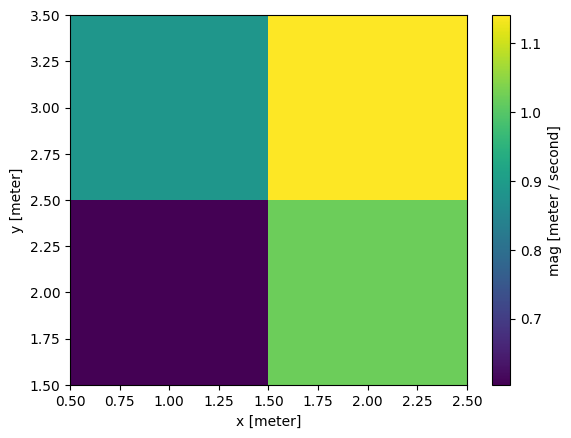

In [6]:
mag.plot()

## 3 Normalization

Data is generally stored in one form (and physical unit) in the HDF5 file. However, in some scientific cases, data may be required in a normalized value.

Consider the following example of a velocity dataset. The accessory `normalize` allows to normalize the data values or the coordinates.

We will show two scenarios: Either the data values are normalized or the attached coordinates, too (or both).

In [7]:
from h5rdmtoolbox.extensions import normalize

Normalize the data by various reference values, here `x_ref` and `phi`. Note, that a unit may be provided:

In [8]:
with h5tbx.File() as h5:
    h5.create_dataset('x', data=[1, 2, 3], make_scale=True, attrs={'units': 'm'})
    h5.create_dataset('y', data=[1, 2, 3, 4], make_scale=True, attrs={'units': 'm'})
    h5.create_dataset('u', data=np.random.random((4, 3)), attach_scales=('y', 'x'))
    h5.create_dataset('v', data=np.random.random((4, 3)), attach_scales=('y', 'x'))

    x_norm = h5.x.normalize(x_ref='2 m', phi=3)[1]

x_norm

<xarray.DataArray 'x/x_ref/phi' ()>
0.3333
Attributes:
    units:

Now, let's normalize the velocity "u" **and its coordinate** x:

In [9]:
with h5tbx.File(h5.hdf_filename) as h5:
    u_norm = h5.u.normalize(u_ref='2 m/s', name='uu').x(x_ref='2 m', phi=3, name='epsilon').isel(y=0)

In [10]:
u_norm

<xarray.DataArray 'uu' (epsilon: 3)>
0.4201 0.2418 0.02388
Coordinates:
    y        int32 1
  * epsilon  (epsilon) float64 0.1667 0.3333 0.5
Attributes:
    units:    s/m

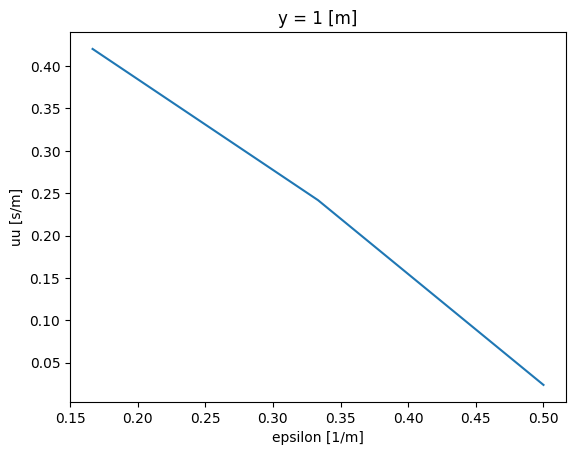

In [11]:
u_norm.plot()

## 4. Converting units

The accessory "to_units" will convert the selected data to the desired units. This assumes, that the unit attribute is called "units". It is also possible to change the units of 
attached dimensions. In the following examples this is done.

Note, that not the dataset values itself changes in the file, but whatever data is accessed by the following slice operation.

In [12]:
from h5rdmtoolbox.extensions import units

In [13]:
with h5tbx.File(mode='w') as h5:
    h5.create_dataset('x', data=[1, -4.5, 5.71], attrs={'units': 'm'},
                          make_scale=True)
    ds = h5.create_dataset('u', data=[1, -4.5, 5.71], attrs={'units': 'm/s'},
                           attach_scale='x')
    u_mm = h5.u.to_units('mm/s', x='mm')[1:2]
u_mm

<xarray.DataArray 'u' (x: 1)>
-4.5e+03
Coordinates:
  * x        (x) float64 -4.5e+03
Attributes:
    units:    mm/s

## Custom accessory

Besides the already implemented ones, users can register custom accessories, too. In the following example, we add "device" as a "property with methods". So "device" appears as a property which has a method "add". Such an implementation facilitates the interaction with HDF data, too. Note, that this "property-like" accessory is available for all `Dataset` objects from now on in this session:

In [16]:
from h5rdmtoolbox.wrapper.accessory import register_special_dataset

@register_special_dataset('device', h5tbx.Dataset, overwrite=True)
class DeviceProperty:
    """Device Accessor class"""

    def __init__(self, ds):
        self._ds = ds
        self._device_name = 'NoDeviceName'
        
    def add(self, new_device_name):
        """adds the attribute device_name to the dataset"""
        self._ds.attrs['device_name'] = new_device_name
        
    @property
    def name(self):
        return self._ds.attrs['device_name']

In [17]:
with h5tbx.File() as h5:
    ds = h5.create_dataset('test', shape=(2,))
    print(type(ds))
    ds.device.add('my device')
    print(ds.device.name)

<class 'h5rdmtoolbox.wrapper.core.Dataset'>
my device
